In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Initialization

In [1]:
import collections
import math
import os.path
import random
import time
import traceback
from multiprocessing import Process, Lock

import json
import pandas as pd
import requests

I place the API keys I use inside api_keys.txt to keep them private.

In [2]:
with open('api_keys.txt', 'r') as f:
    api_keys = json.load(f)
    riot_api_key = api_keys['riot-api-key']
    championgg_api_key = api_keys['champion-gg-api-key']

## API call helper methods

In [13]:
def make_request(url, **kwargs):
    '''
    Make API call to url, with the given parameters in **kwargs
    
    Parameters
    ----------
    url : str
        Full url used to send request
    **kwargs
        Additional keyword args to pass to `requests.get()`
        
    Returns
    -------
    dict
        JSON from API call converted to a dict
    '''
    r = requests.get(url, **kwargs)
    # Rate limited, wait and redo request
    if r.status_code == 429:
        retry_after = int(r.headers['Retry-After'])
        print(f"Rate limited for request {url}, sleeping for {retry_after} s")
        time.sleep(retry_after)
        return make_request(url, **kwargs)
    elif r.status_code >= 500:
        print(f"Server error {r.status_code}, retrying in 60 s")
        time.sleep(60)
        return make_request(url, **kwargs)
    elif r.status_code != 200:
        print(f"got {r.status_code} error when making request {url}")
        return
    return r.json()


def make_riot_request(uri, region, params=None):
    '''
    Make an call to Riot's API.
    
    Parameters
    ----------
    uri : str
        The desired URI
    region : str
        The desired region (NA1, EUW1, KR, etc.)
    params : dict, optional
        Additional params to append to the GET request
        
    Returns
    -------
    dict
        JSON from API call converted to a dict
    '''
    return make_request(f"https://{region}.api.riotgames.com{uri}", headers={'X-Riot-Token': riot_api_key}, 
                        params=params)


def make_championgg_request(uri, params={}):
    '''
    Make an call to Champion.gg's API.
    
    Parameters
    ----------
    uri : str
        The desired URI
    params : dict, optional
        Additional params to append to the GET request
        
    Returns
    -------
    dict
        JSON from API call converted to a dict
    '''
    params['api_key'] = championgg_api_key  # Add API key to params
    return make_request(f"http://api.champion.gg/v2{uri}", params=params)

## Static data extraction

Create methods to extract static data. Since rate limit for static data is so low, we retrieve it as little as possible.

In [14]:
# Get mapping from summoner spell id to name
spell_id_to_name = make_riot_request('/lol/static-data/v3/summoner-spells', 'NA1', params={'dataById': 'true'})['data']
spell_id_to_name = {int(k): v['name'] for k, v in spell_id_to_name.items()}

In [15]:
# Get mapping from champion id to name
champ_id_to_name = make_riot_request('/lol/static-data/v3/champions', 'NA1', params={'dataById': 'true'})['data']
champ_id_to_name = {int(k): v['name'] for k, v in champ_id_to_name.items()}

In [16]:
# Get number of most recent patch
PATCH = make_riot_request('/lol/static-data/v3/versions', 'NA1')[0]

In [17]:
# Set other game constants
SEASON = 11  # Season 8
RANKED_QUEUE = 420
NORMAL_QUEUE = 400  # Normal draft

# Data Collection

## Helper methods

In [18]:
def is_championgg_tier(tier):
    '''Return True if tier is not diamond, master, or challenger, False otherwise'''
    return tier not in ['DIAMOND', 'MASTER', 'CHALLENGER']

def rank_to_mmr(tier, rank, lp):
    '''
    Convert ranks to continuous scale.
    
    Parameters
    ----------
    tier : str
        Major division (BRONZE, SILVER, GOLD, PLATINUM, DIAMOND, MASTER, CHALLENGER)
    rank : str
        Minor divison (V, IV, III, II, I)
    lp : int
        League points as value from 0-100 (except for Masters+, where lp has no limit)
    
    Returns
    -------
    int
        Number that represents "mmr". Ranges from 0-2500 for ranks under Masters, and 2500+ for Masters+.
    '''
    tier = tier if tier != 'CHALLENGER' else 'MASTER'
    rank = rank if tier != 'CHALLENGER' and tier != 'MASTER' else 'V'
    tier_to_num = {'BRONZE': 0, 'SILVER': 1, 'GOLD': 2, 'PLATINUM': 3, 'DIAMOND': 4, 'MASTER': 5}
    rank_to_tier = {'V': 0, 'IV': 1, 'III': 2, 'II': 3, 'I': 4}
    return tier_to_num[tier] * 500 + rank_to_tier[rank] * 100 + lp


def get_roles(participants, match_id, region):
    '''
    Manually determine which player is in which role, since Riot API's automatic labeling is not very accurate.

    Parameters
    ----------
    x : list
        List of participants as given by Riot API when querying match
    match_id : int
        ID of desired match
    region : str
        Region to query match from
        
    Returns
    -------
    dict
        Mapping of participant ids to their role (TOP, JUNGLE, MIDDLE, DUO_CARRY, DUO_SUPPORT)
    '''
    roles = {}
    unique_roles = set()
    team_100 = {p['participantId']: p for p in participants if p['teamId'] == 100}
    team_200 = {p['participantId']: p for p in participants if p['teamId'] == 200}
    match_frames = make_riot_request(f"/lol/match/v3/timelines/by-match/{match_id}", region)['frames']
    for team_id, team in {'100': team_100, '200': team_200}.items():
        # Find junglers by seeing who has smite summoner spell
        role = 'JUNGLE'
        unique_role = role + team_id
        for pid, p in team.items():
            if spell_id_to_name[p['spell1Id']] == 'Smite' or spell_id_to_name[p['spell2Id']] == 'Smite':
                if unique_role in unique_roles:  # Return if more than 1 smite on a team
                    print('More than one person has smite on a team')
                    return
                roles[pid] = role
                unique_roles.add(unique_role)
        if unique_role not in unique_roles:  # Return if no smite on a team
            print('No smite on a team')
            return
        
        # Label support as summoner with least cs
        support_id = min(team.values(), key=lambda p: p['stats']['totalMinionsKilled'] + 
                         p['stats']['neutralMinionsKilled'])['participantId']
        if support_id in roles:  # Make sure jungle isn't relabeled as support
            print('Jungle got relabeled as support')
            return
        role = 'DUO_SUPPORT'
        roles[support_id] = role
        unique_roles.add(role + team_id)
        
        # Label top, mid, and adc based on position by level 2+
        lane_pos = {'TOP': (2000, 14881 - 2000), 'MIDDLE': (14820 / 2, 14881 / 2), 'DUO_CARRY': (14820 - 2000, 2000)}
        num_assigned = 0
        for frame in match_frames:
            for pid, p in {int(k): v for k, v in frame['participantFrames'].items()}.items():
                if pid in team and p['level'] >= 2 and pid not in roles:
                    if 'position' not in p:
                        continue
                    dists = {lane: math.hypot(p['position']['x'] - pos[0], p['position']['y'] - pos[1]) 
                             for lane, pos in lane_pos.items()}  # Distance between summoner and center of lane
                    if min(dists.values()) > 2000:  # Continue if too far away from center of lane
                        continue
                    role = min(dists, key=dists.get)  # Chose lane that summoner is closest to
                    unique_role = role + team_id
#                     print(p['position']['x'], p['position']['y'])
#                     print(dists)
                    if unique_role in unique_roles:  # Return if role is repeated
                        print(f"Role {role} repeated on a team")
#                         print([champ_id_to_name[participants[int(i) - 1]['championId']] for i in roles])
#                         print(champ_id_to_name[participants[pid - 1]['championId']])
                        return
                    roles[pid] = role
                    unique_roles.add(unique_role)
                    num_assigned += 1
            if num_assigned == 3:
                break
        if num_assigned != 3:  # Return if someone didn't reach lvl 2 (such as disconnect)
            print('Someone did not reach lvl 2 in the game')
            return
        
    return roles


def capitalize(s):
    '''Capitalize first letter in a word'''
    return s[0].capitalize() + s[1:]


def store_championgg_stats(summoner, role_info, champ_stats, blank=False):
    '''
    Transfer general champion stats, positions, and previous positions in role from champion.gg to summoner
    
    Parameters
    ----------
    summoner : dict
        Summoner that will store the champion stats
    role_info : dict
        Dictionary of general stats for a champion in a role
    champ_stats : list
        Champion stats that are being stored
    blank : bool, optional
        Whether to fill stats as N/A
    '''
    for stat in champ_stats:
        prefix = 'champion' + capitalize(stat)
        suffix = 's' if stat != 'overallPerformanceScore' else ''
        if stat != 'overallPerformanceScore':
            summoner[prefix] = role_info[stat] if not blank else 'N/A'
        summoner[prefix + 'Position'] = role_info['positions'][stat + suffix] if not blank else 'N/A'
        if 'previous' + capitalize(stat) + suffix not in role_info['positions'] or blank:
            summoner[prefix + 'PreviousPosition'] = 'N/A'
        else:
            summoner[prefix + 'PreviousPosition'] = role_info['positions']['previous' + capitalize(stat) + suffix]


def store_cdragon_stats(summoner, champ_stats):
    '''
    Transfer general champion stats from CommunityDragon to summoner
    
    Parameters
    ----------
    summoner : dict
        Summoner that will store the champion stats
    champ_stats : dict
        Champion stats that are being stored
    '''
    for k, v in champ_stats.items():
        summoner['champion' + capitalize(k)] = v  # Capitalize first letter of stat for camelCase
        

def store_matchup(summoner_matchup, role):
    '''
    Transfer winrates in the lane matchup to the summoners in the matchup
    
    Parameters
    ----------
    summoner_matchup : list
        List of the two summoners in the matchup
    role : str
        Role for the matchup
    
    Returns
    -------
    bool
        True if we successfully found the matchup through champion.gg, False otherwise
    '''
    champ_ids = [summoner['championId'] for summoner in summoner_matchup]
    for summoner, champ_id in zip(summoner_matchup, champ_ids):
        params = {'elo': summoner['tier']} if is_championgg_tier(summoner['tier']) else {}
        params['limit'] = 500  # High limit b/c of synergy and adc/support matchups
        matchup_data = make_championgg_request(f"/champions/{champ_id}/{role}/matchups", params=params)
        for matchup in matchup_data:
            # Continue if too little data, not direct matchup (synergy, etc.), or desired champs are not included
            if (matchup['count'] < 10 or matchup['role'] != role
                    or not all(champ_id in matchup['_id'].values() for champ_id in champ_ids)):
                continue
            for summoner in summoner_matchup:
                matchup_champ_data = (matchup['champ1'] if summoner['championId'] == matchup['champ1_id']
                    else matchup['champ2'])
                summoner['matchupWinRate'] = matchup_champ_data['winrate']
            return True
    return False

##  Feature extraction from match

In [11]:
def get_match(match_id, region):
    '''
    Retrieve data for all 10 summoners given a match.
    
    Parameters
    ----------
    match_id : int
        Match id to query
    region : str
        Region to query from
        
    Returns
    -------
    OrderedDict
        Return dictionary of features described below
        We store the following stats for convenience (removed later):
        - summonerId
        - accountId
        - summoner name
        - champion name
        We store the following general stats per summoner from Riot API:
        - role (TOP, JUNGLE, MIDDLE, DUO_CARRY, DUO_SUPPORT)
        - team id (100 for blue or 200 for red)
        - champion id
        - mastery points for champion
        - whether summoner is on "hot streak"
        - whether summoner is "veteran" in league (100+ games played)
        - whether summoner is "fresh blood" (new to league)
        - summoner winrate in ranked
        - total number of ranked games
        - tier (BRONZE, SILVER, GOLD, PLATINUM, DIAMOND, MASTER, CHALLENGER)
        - mmr (from 0 to 2500+)
        - hours between match and the previous ranked or normal match
        - percent of games played as same role in last 10 games
        - percent of games played as same role in last 50 games
        - percent of games that were ranked in last 50 games
        - percent of games that were played with the same champion in last 50 games
        - percent of games that were played in ranked with the same champion in last 50 games
        We store the following champion.gg stats, as well as their position and previous position within role:
        - champion ban rate
        - champion win rate in role (may be N/A)
        - champion play rate in role (may be N/A)
        We store the following additional champion.gg stats:
        - champion.gg's performance score for the champion in role (may be N/A)
        - champion.gg's previous performance score for the champion in role (may be N/A)
        - champion percent played in role (may be N/A)
        - winrate for lane matchup (may be N/A)
        We store the following general champion stats from CommunityDragon:
        - champion "style" as a scale, with 1 using autoattacks only and 10 using abilities only
        - champion difficulty on scale of 1 to 3
        - champion main damage type (physical or magic)
        - champion damage on scale of 1 to 3
        - champion durability on scale of 1 to 3
        - champion crowd control on scale of 1 to 3
        - champion mobility on scale of 1 to 3
        - champion utility on scale of 1 to 3
    '''
    # Hope that Riot API's automatic role labeling is correct
    get_match_role = lambda match: match['lane'] if match['lane'] != 'BOTTOM' else match['role']
    mmr_to_tier = lambda mmr: {0: 'BRONZE', 1: 'SILVER', 2: 'GOLD', 3: 'PLATINUM', 4: 'DIAMOND', 5: 'MASTER'}[mmr // 500]
    
    match_content = make_riot_request(f"/lol/match/v3/matches/{match_id}", region)
    if not match_content:
        return
    # Must be current patch
    if PATCH[:-2] not in match_content['gameVersion']:
        print('Not current patch')
        return
    # Must be Ranked Solo/Duo game
    if match_content['queueId'] != RANKED_QUEUE:
        print('Not a ranked solo/duo game')
        return
    
    # Store very basic data needed for other API calls
    data = collections.defaultdict(collections.OrderedDict)
    for p in match_content['participantIdentities']:
        summoner = data[p['participantId']]
        summoner['summonerId'] = p['player']['summonerId']
        summoner['accountId'] = p['player']['currentAccountId']
        summoner['summonerName'] = p['player']['summonerName']
    for p in match_content['participants']:
        summoner = data[p['participantId']]
        summoner['teamId'] = p['teamId']
        summoner['championId'] = p['championId']
        summoner['championName'] = champ_id_to_name[summoner['championId']]
    
    # Store roles for each player
    roles = get_roles(match_content['participants'], match_id, region)
    if not roles:
        print('Could not determine roles for players')
        return
    for pid, summoner in data.items():
        summoner['role'] = roles[pid]
        
    # Store ranked stats
    unranked = collections.defaultdict(list)  # Keep track of unranked players
    team_mmr = collections.defaultdict(int)
    for summoner in data.values():
        ranked_content = make_riot_request(f"/lol/league/v3/positions/by-summoner/{summoner['summonerId']}", region)
        if not ranked_content:
            unranked[summoner['teamId']].append(summoner)
            continue
        found_queue = False
        for queue in ranked_content:
            if queue['queueType'] == 'RANKED_SOLO_5x5':
                summoner['hotStreak'] = queue['hotStreak']
                summoner['veteran'] = queue['veteran']
                summoner['freshBlood'] = queue['freshBlood']
                summoner['summonerWinRate'] = queue['wins'] / (queue['wins'] + queue['losses'])
                summoner['totalRankedGames'] = queue['wins'] + queue['losses']
                summoner['tier'] = queue['tier']
                summoner['mmr'] = rank_to_mmr(queue['tier'], queue['rank'], queue['leaguePoints'])
                team_mmr[summoner['teamId']] += summoner['mmr']
                found_queue = True
                break
        if not found_queue:
            unranked[summoner['teamId']].append(summoner)
    # Assign average team mmr to unranked summoners
    for team, total_mmr in team_mmr.items():
        avg_mmr = total_mmr / (5 - len(unranked[team]))
        for summoner in unranked[team]:
            summoner['hotStreak'] = False
            summoner['veteran'] = False
            summoner['freshBlood'] = True
            summoner['summonerWinRate'] = 0.5
            summoner['totalRankedGames'] = 0
            summoner['tier'] = mmr_to_tier(avg_mmr)
            summoner['mmr'] = avg_mmr
    
    for summoner in data.values():
        # Store mastery points of given champion
        mastery_content = make_riot_request(f"/lol/champion-mastery/v3/champion-masteries/by-summoner/"
                                            f"{summoner['summonerId']}/by-champion/{summoner['championId']}", region)
        if mastery_content:
            summoner['masteryPoints'] = mastery_content['championPoints']
        else:
            summoner['masteryPoints'] = 0
                                
        # Store data from the summoner's previous matches
        match_list = make_riot_request(f"/lol/match/v3/matchlists/by-account/{summoner['accountId']}", region, 
                                       params={'season': SEASON, 'queue': [RANKED_QUEUE, NORMAL_QUEUE], 'endIndex': 50})['matches']
        # Make sure we only consider games before the desired game
        for i, match in enumerate(match_list):
            if match['gameId'] == match_content['gameId']:
                match_list = match_list[(i+1):]
        if len(match_list) == 0:
            print(f"No previous matches for this season for summoner {summoner['summonerName']}")
            return
        
        summoner['hoursSincePreviousGame'] = (match_content['gameCreation'] - match_list[0]['timestamp']) / (1000 * 60 * 60)
        is_same_role = [get_match_role(match) == summoner['role'] for match in match_list]
        summoner['percentRolePlayedLast10'] = sum(is_same_role[:10]) / len(is_same_role[:10])
        summoner['percentRolePlayedLast50'] = sum(is_same_role) / len(is_same_role)
        is_ranked_match = [match['queue'] == RANKED_QUEUE for match in match_list]
        summoner['percentRankedGamesPlayed'] = sum(is_ranked_match) / len(is_ranked_match)
        is_game_as_champ = [match['champion'] == summoner['championId'] for match in match_list]
        summoner['percentGamesWithChampion'] = sum(is_game_as_champ) / len(is_game_as_champ)
        is_ranked_game_as_champ = [x and y for x, y in zip(is_ranked_match, is_game_as_champ)]
        summoner['percentRankedGamesWithChampion'] = sum(is_ranked_game_as_champ) / len(is_ranked_game_as_champ)
        
        previous_game = make_riot_request(f"/lol/match/v3/matches/{match_list[0]['gameId']}", region)
        for prev_p in previous_game['participantIdentities']:
            if prev_p['player']['summonerId'] == summoner['summonerId']:
                pid = prev_p['participantId']
                summoner['previousGameWon'] = previous_game['participants'][prev_p['participantId'] - 1]['stats']['win']
        
        # Store general champion stats from champion.gg
        params = {'champData': 'positions'}
        if is_championgg_tier(summoner['tier']):
            params['elo'] = summoner['tier']
        champ_content_championgg = make_championgg_request(f"/champions/{summoner['championId']}", params=params)
        
        store_championgg_stats(summoner, champ_content_championgg[0], ['banRate'])
        # If we can't get stats for champion in that role, assign as N/A
        found_role = False
        for role_info in champ_content_championgg:
            if role_info['role'] == summoner['role']:
                store_championgg_stats(summoner, role_info, ['winRate', 'playRate', 'overallPerformanceScore'])
                summoner['championPercentRolePlayed'] = role_info['percentRolePlayed']
                found_role = True
                break
        if not found_role:
            store_championgg_stats(summoner, role_info, ['winRate', 'playRate', 'overallPerformanceScore'], blank=True)
            summoner['championPercentRolePlayed'] = 'N/A'
                
        # Store more general champion stats from CommunityDragon
        champ_content_cdragon = make_request(f"http://cdn.communitydragon.org/{PATCH}/champion/"
                                             f"{summoner['championId']}/data")
        # Store style, difficulty, and damage type
        store_cdragon_stats(summoner, champ_content_cdragon['tacticalInfo'])
        # Store damage, durability, crowd control, mobility, and utility
        store_cdragon_stats(summoner, champ_content_cdragon['playstyleInfo'])
                
    # Store winrates for lane matchups
    for role in ['TOP', 'JUNGLE', 'MIDDLE', 'DUO_CARRY', 'DUO_SUPPORT']:
        summoner_matchup = [summoner for summoner in data.values() if summoner['role'] == role]
        found_matchup = store_matchup(summoner_matchup, role)
        if not found_matchup:
            for summoner in summoner_matchup:
                summoner['matchupWinRate'] = 'N/A'
#             print(f"Could not find matchup between {champ_id_to_name[summoner_matchup[0]['championId']]} and "
#                   f"{champ_id_to_name[summoner_matchup[1]['championId']]} in role {role}")
                        
    return data

## Obtain list of league ids

We want our sample of matches to accurately match the distribution of ranks. Therefore, we use a list of league ids compiled by canisback, which is close enough to the real distribution.

In [11]:
for region in ['euw1', 'kr', 'na1']:
    file_name = f"league_{region}.csv"
    if not os.path.isfile(file_name):
        r = requests.get(f"http://canisback.com/leagueId/{file_name}.csv")
        with open(file_name, 'wb') as f:  
            f.write(r.content)

## Data collection

In [18]:
def collect_data(region, lock):
    '''Collect matches from a region, and store in a csv'''
    skip_rows = 40
    region_df = pd.read_csv(f"league_{region}.csv", skiprows=range(1, skip_rows))[['leagueId', 'tier']]
    total_queries = 0
    total_games = 0
    for i, row in region_df.iterrows():
        print(f"Querying league #{i} from region {region}")
        league = make_riot_request(f"/lol/league/v3/leagues/{row['leagueId']}", region)['entries']
        for summoner in league:
            total_queries += 1
            # Select most recent game played by summoner
            account_id = make_riot_request(f"/lol/summoner/v3/summoners/{summoner['playerOrTeamId']}", region)['accountId']
            match_list = make_riot_request(f"/lol/match/v3/matchlists/by-account/{account_id}", region, 
                                          params={'queue': RANKED_QUEUE, 'season': SEASON, 'endIndex': 1})['matches']
            if len(match_list) == 0:
                continue
            try:
                match_data = get_match(match_list[0]['gameId'], region)
            except Exception as e:
                traceback.print_exc()
                continue
            if not match_data:
                continue
            
            # Make sure we have columns in exact same order
            # Also split each match into 2 datapoints, with teams swapped
            match_data = match_data.values()
            ally100 = pd.Series()
            ally200 = pd.Series()
            for team_id, team_data in {100: ally100, 200: ally200}.items():
                ally_team = [summoner for summoner in match_data if summoner['teamId'] == team_id]
                enemy_team = [summoner for summoner in match_data if summoner['teamId'] != team_id]
                for role in ['TOP', 'JUNGLE', 'MIDDLE', 'DUO_CARRY', 'DUO_SUPPORT']:
                    summoner = [summoner for summoner in ally_team if summoner['role'] == role][0]
                    for k, v in summoner.items():
                        team_data['ally' + role + k] = v
                for role in ['TOP', 'JUNGLE', 'MIDDLE', 'DUO_CARRY', 'DUO_SUPPORT']:
                    summoner = [summoner for summoner in enemy_team if summoner['role'] == role][0]
                    for k, v in summoner.items():
                        team_data['enemy' + role + k] = v
            ally100['region'] = region
            ally200['region'] = region
            
            df = pd.DataFrame(columns=ally100.index)
            df = df.append(ally100, ignore_index=True)
            df = df.append(ally200, ignore_index=True)
                        
            # Write to file
            lock.acquire()
            data_file = 'summoner_data.csv'
            header = False
            if not os.path.isfile(data_file):
                header = True
            elif os.path.getsize(data_file) > 10**9:  # Don't let file exceed 1 GB
                return
            with open(data_file, 'a') as f:
                df.to_csv(f, index=False, header=header)
            lock.release()
            
            total_games += 1
            print(f"Collected {total_games} games from region {region}")
            print(f"Queried {total_queries} games from region {region}")
    print(f"Queried all possible games from region {region}")

Query matches from EUW, KR, and NA at the same time.

In [17]:
data_collect_flag = False
if data_collect_flag:
    lock = Lock()
    for region in ['euw1', 'kr', 'na1']:
        Process(target=collect_data, args=(region, lock)).start()

Querying league #0 from region euw1
Querying league #0 from region na1
Querying league #0 from region kr
Not current patch
Not current patch
Not current patch
Collected 1 games from region na1
Queried 1 games from region na1
Collected 1 games from region euw1
Queried 4 games from region euw1
Collected 2 games from region na1
Queried 2 games from region na1
Collected 1 games from region kr
Queried 1 games from region kr
Not current patch
Not current patch
Not current patch
Not current patch
Rate limited for request https://na1.api.riotgames.com/lol/match/v3/matches/2720962923, sleeping for 68 s
Not current patch
No previous matches for this season for summoner EC EnglishCorner
Not current patch
Not current patch
Rate limited for request https://euw1.api.riotgames.com/lol/summoner/v3/summoners/36786908, sleeping for 54 s
Collected 2 games from region kr
Queried 4 games from region kr
Rate limited for request https://kr.api.riotgames.com/lol/league/v3/positions/by-summoner/50711615, sleep

Collected 19 games from region kr
Queried 34 games from region kr
Collected 18 games from region euw1
Queried 48 games from region euw1
Not current patch
Not current patch
Not current patch
Role DUO_CARRY repeated on a team
Could not determine roles for players
Not current patch
Not current patch
Not current patch
Jungle got relabeled as support
Could not determine roles for players
Not current patch
Collected 20 games from region na1
Queried 54 games from region na1
Not current patch
Not current patch
More than one person has smite on a team
Could not determine roles for players
Not current patch
Not current patch
Not current patch
Not current patch
Collected 20 games from region kr
Queried 35 games from region kr
Not current patch
Not current patch
Rate limited for request https://na1.api.riotgames.com/lol/match/v3/matches/2807610084, sleeping for 69 s
Collected 19 games from region euw1
Queried 58 games from region euw1
Not current patch
Not current patch
Role DUO_CARRY repeated on 

Could not determine roles for players
Not current patch
Not current patch
Not current patch
Rate limited for request https://euw1.api.riotgames.com/lol/match/v3/matchlists/by-account/235351794, sleeping for 50 s
Collected 35 games from region kr
Queried 73 games from region kr
Not current patch
Not current patch
Rate limited for request https://kr.api.riotgames.com/lol/league/v3/positions/by-summoner/19623613, sleeping for 14 s
Collected 33 games from region euw1
Queried 108 games from region euw1
Collected 36 games from region kr
Queried 76 games from region kr
No previous matches for this season for summoner BaekSeol
Not current patch
Not current patch
Not current patch
Collected 34 games from region euw1
Queried 109 games from region euw1
Not current patch
Collected 37 games from region kr
Queried 77 games from region kr
Rate limited for request https://euw1.api.riotgames.com/lol/match/v3/matchlists/by-account/225948304, sleeping for 29 s
Not current patch
Collected 34 games from re

Collected 47 games from region na1
Queried 165 games from region na1
Role DUO_CARRY repeated on a team
Could not determine roles for players
Collected 52 games from region kr
Queried 106 games from region kr
Not current patch
Not current patch
Not current patch
Not current patch
Rate limited for request https://kr.api.riotgames.com/lol/league/v3/positions/by-summoner/66661002, sleeping for 10 s
Rate limited for request https://na1.api.riotgames.com/lol/champion-mastery/v3/champion-masteries/by-summoner/31379228/by-champion/81, sleeping for 47 s
Collected 53 games from region kr
Queried 108 games from region kr
Collected 47 games from region euw1
Queried 165 games from region euw1
Collected 48 games from region na1
Queried 170 games from region na1
Collected 48 games from region euw1
Queried 166 games from region euw1
Collected 49 games from region na1
Queried 171 games from region na1
Not current patch
Not current patch
No smite on a team
Could not determine roles for players
Someone d

Querying league #1 from region euw1
Collected 70 games from region kr
Queried 131 games from region kr
Not current patch
Collected 63 games from region euw1
Queried 201 games from region euw1
Rate limited for request https://euw1.api.riotgames.com/lol/match/v3/matches/3673096310, sleeping for 48 s
Collected 64 games from region na1
Queried 226 games from region na1
Not current patch
Collected 71 games from region kr
Queried 133 games from region kr
Collected 65 games from region na1
Queried 228 games from region na1
Not current patch
Not current patch
Not current patch
Rate limited for request https://kr.api.riotgames.com/lol/champion-mastery/v3/champion-masteries/by-summoner/1391376/by-champion/63, sleeping for 18 s
Rate limited for request https://na1.api.riotgames.com/lol/league/v3/positions/by-summoner/56863043, sleeping for 70 s
Collected 64 games from region euw1
Queried 202 games from region euw1
Not current patch
Collected 72 games from region kr
Queried 134 games from region k

Collected 89 games from region kr
Queried 163 games from region kr
Rate limited for request https://kr.api.riotgames.com/lol/match/v3/matchlists/by-account/204763012, sleeping for 14 s
Not current patch
Collected 81 games from region euw1
Queried 247 games from region euw1
Collected 82 games from region euw1
Queried 248 games from region euw1
Not current patch
Collected 90 games from region kr
Queried 165 games from region kr
Not current patch
Rate limited for request https://euw1.api.riotgames.com/lol/champion-mastery/v3/champion-masteries/by-summoner/88777992/by-champion/33, sleeping for 49 s
Collected 83 games from region na1
Queried 265 games from region na1
Not current patch
Collected 91 games from region kr
Queried 167 games from region kr
Collected 84 games from region na1
Queried 267 games from region na1
Role DUO_CARRY repeated on a team
Could not determine roles for players
Not current patch
Rate limited for request https://kr.api.riotgames.com/lol/league/v3/positions/by-summ

got 404 error when making request https://euw1.api.riotgames.com/lol/match/v3/matches/1979967446


Traceback (most recent call last):
  File "<ipython-input-16-ba5709d79b18>", line 22, in collect_data
    match_data = get_match(match_list[0]['gameId'], region)
  File "<ipython-input-12-3ea8e61b7768>", line 162, in get_match
    for prev_p in previous_game['participantIdentities']:
TypeError: 'NoneType' object is not subscriptable


Collected 97 games from region euw1
Queried 291 games from region euw1
Collected 106 games from region kr
Queried 201 games from region kr
Server error 503, retrying in 60 s
Collected 98 games from region euw1
Queried 292 games from region euw1
Rate limited for request https://euw1.api.riotgames.com/lol/summoner/v3/summoners/19325652, sleeping for 49 s
Collected 99 games from region na1
Queried 307 games from region na1
Not current patch
Collected 100 games from region na1
Queried 309 games from region na1
Not current patch
Not current patch
Not current patch
Not current patch
Not current patch
Not current patch
Not current patch
Not current patch
Not current patch
Not current patch
Not current patch
Rate limited for request https://na1.api.riotgames.com/lol/league/v3/positions/by-summoner/24798829, sleeping for 67 s
Not current patch
Collected 99 games from region euw1
Queried 294 games from region euw1
Not current patch
Not current patch
Collected 107 games from region kr
Queried 204

Queried 237 games from region kr
Collected 116 games from region na1
Queried 354 games from region na1
Not current patch
Not current patch
Rate limited for request https://kr.api.riotgames.com/lol/champion-mastery/v3/champion-masteries/by-summoner/2127636/by-champion/91, sleeping for 21 s
Rate limited for request https://na1.api.riotgames.com/lol/match/v3/matchlists/by-account/48121973, sleeping for 66 s
Collected 114 games from region euw1
Queried 350 games from region euw1
Not current patch
Not current patch
Not current patch
Collected 124 games from region kr
Queried 239 games from region kr
Not current patch
Not current patch
Collected 115 games from region euw1
Queried 354 games from region euw1
Not current patch
Collected 117 games from region na1
Queried 356 games from region na1
Role DUO_CARRY repeated on a team
Could not determine roles for players
Rate limited for request https://euw1.api.riotgames.com/lol/league/v3/positions/by-summoner/71360171, sleeping for 51 s
Not curren

Not current patch
Collected 139 games from region kr
Queried 284 games from region kr
Collected 132 games from region na1
Queried 414 games from region na1
Not current patch
Rate limited for request https://na1.api.riotgames.com/lol/match/v3/matchlists/by-account/35686416, sleeping for 69 s
No previous matches for this season for summoner 숲속의 마이
Rate limited for request https://kr.api.riotgames.com/lol/summoner/v3/summoners/60601153, sleeping for 19 s
Collected 131 games from region euw1
Queried 387 games from region euw1
Collected 140 games from region kr
Queried 286 games from region kr
Collected 132 games from region euw1
Queried 388 games from region euw1
Not current patch
Not current patch
Not current patch
Not current patch
Not current patch
Not current patch
Rate limited for request https://euw1.api.riotgames.com/lol/match/v3/matchlists/by-account/216839991, sleeping for 49 s
Collected 133 games from region na1
Queried 416 games from region na1
Collected 134 games from region na

Rate limited for request https://kr.api.riotgames.com/lol/league/v3/positions/by-summoner/4562980, sleeping for 21 s
Collected 146 games from region euw1
Queried 439 games from region euw1
Not current patch
Not current patch
Collected 147 games from region euw1
Queried 442 games from region euw1
Not current patch
Collected 157 games from region kr
Queried 318 games from region kr
Not current patch
Collected 148 games from region na1
Queried 466 games from region na1
Not current patch
Rate limited for request https://euw1.api.riotgames.com/lol/match/v3/matches/3673997170, sleeping for 50 s
Not current patch
Collected 149 games from region na1
Queried 469 games from region na1
Collected 158 games from region kr
Queried 320 games from region kr
Jungle got relabeled as support
Could not determine roles for players
Not current patch
Not current patch
Rate limited for request https://na1.api.riotgames.com/lol/champion-mastery/v3/champion-masteries/by-summoner/26199362/by-champion/12, sleepin

Rate limited for request https://na1.api.riotgames.com/lol/match/v3/matchlists/by-account/37931553, sleeping for 71 s
Rate limited for request https://kr.api.riotgames.com/lol/match/v3/matchlists/by-account/200340674, sleeping for 22 s
Not current patch
Not current patch
Not current patch
Not current patch
Collected 163 games from region euw1
Queried 486 games from region euw1
Collected 173 games from region kr
Queried 361 games from region kr
Not current patch
Collected 164 games from region na1
Queried 512 games from region na1
Collected 164 games from region euw1
Queried 487 games from region euw1
Not current patch
Rate limited for request https://euw1.api.riotgames.com/lol/match/v3/matchlists/by-account/31422113, sleeping for 50 s
Collected 165 games from region na1
Queried 514 games from region na1
Not current patch
Collected 174 games from region kr
Queried 363 games from region kr
Collected 166 games from region na1
Queried 516 games from region na1
Rate limited for request http

Not current patch
Not current patch
Rate limited for request https://na1.api.riotgames.com/lol/match/v3/timelines/by-match/2807827719, sleeping for 74 s
Rate limited for request https://kr.api.riotgames.com/lol/match/v3/matchlists/by-account/201575154, sleeping for 21 s
Collected 178 games from region euw1
Queried 536 games from region euw1
Collected 188 games from region kr
Queried 398 games from region kr
Not current patch
Not current patch
Collected 179 games from region euw1
Queried 539 games from region euw1
Not current patch
Not current patch
Not current patch
Not current patch
Rate limited for request https://euw1.api.riotgames.com/lol/match/v3/matches/3665255954, sleeping for 50 s
Collected 189 games from region kr
Queried 399 games from region kr
Querying league #2 from region kr
Not current patch
Not current patch
Not current patch
Collected 180 games from region na1
Queried 571 games from region na1
Not current patch
Not current patch
Collected 181 games from region na1
Quer

Rate limited for request https://kr.api.riotgames.com/lol/match/v3/matches/3245435829, sleeping for 14 s
Collected 193 games from region euw1
Queried 590 games from region euw1
Not current patch
Not current patch
Not current patch
Collected 204 games from region kr
Queried 446 games from region kr
Not current patch
Not current patch
Not current patch
Collected 194 games from region euw1
Queried 596 games from region euw1
Not current patch
Rate limited for request https://euw1.api.riotgames.com/lol/match/v3/matches/3669810629, sleeping for 49 s
Collected 195 games from region na1
Queried 625 games from region na1
No previous matches for this season for summoner 저러고있어도되나
Collected 196 games from region na1
Queried 626 games from region na1
No previous matches for this season for summoner S6forTsm
Not current patch
Rate limited for request https://na1.api.riotgames.com/lol/champion-mastery/v3/champion-masteries/by-summoner/78531725/by-champion/20, sleeping for 70 s
Role MIDDLE repeated on

Collected 207 games from region euw1
Queried 646 games from region euw1
Jungle got relabeled as support
Could not determine roles for players
Collected 218 games from region kr
Queried 481 games from region kr
Not current patch
Not current patch
Rate limited for request https://euw1.api.riotgames.com/lol/champion-mastery/v3/champion-masteries/by-summoner/32828231/by-champion/5, sleeping for 53 s
Not current patch
Not current patch
Collected 208 games from region na1
Queried 687 games from region na1
Not current patch
Collected 219 games from region kr
Queried 482 games from region kr
Rate limited for request https://na1.api.riotgames.com/lol/match/v3/matches/2807915859, sleeping for 72 s
Rate limited for request https://kr.api.riotgames.com/lol/match/v3/matches/3245418158, sleeping for 22 s
Collected 208 games from region euw1
Queried 648 games from region euw1
Not current patch
Role MIDDLE repeated on a team
Could not determine roles for players
Not current patch
Not current patch
Not

Collected 222 games from region euw1
Queried 685 games from region euw1
Rate limited for request https://kr.api.riotgames.com/lol/match/v3/matchlists/by-account/4479046, sleeping for 19 s
Collected 234 games from region kr
Queried 517 games from region kr
Collected 223 games from region euw1
Queried 686 games from region euw1
Not current patch
Not current patch
Not current patch
Rate limited for request https://euw1.api.riotgames.com/lol/match/v3/matches/3673679034, sleeping for 49 s
Collected 222 games from region na1
Queried 749 games from region na1
Not current patch
Not current patch
Not current patch
Collected 235 games from region kr
Queried 521 games from region kr
Collected 223 games from region na1
Queried 753 games from region na1
Not current patch
Not current patch
Rate limited for request https://na1.api.riotgames.com/lol/match/v3/matchlists/by-account/43492469, sleeping for 68 s
Collected 224 games from region euw1
Queried 687 games from region euw1
Rate limited for reques

Traceback (most recent call last):
  File "<ipython-input-16-ba5709d79b18>", line 22, in collect_data
    match_data = get_match(match_list[0]['gameId'], region)
  File "<ipython-input-12-3ea8e61b7768>", line 162, in get_match
    for prev_p in previous_game['participantIdentities']:
TypeError: 'NoneType' object is not subscriptable


Not current patch
Not current patch
Not current patch
Not current patch
Rate limited for request https://euw1.api.riotgames.com/lol/league/v3/positions/by-summoner/24237316, sleeping for 53 s
Collected 231 games from region na1
Queried 779 games from region na1
Not current patch
Not current patch
Not current patch
Collected 245 games from region kr
Queried 544 games from region kr
Collected 232 games from region na1
Queried 783 games from region na1
Jungle got relabeled as support
Could not determine roles for players
Rate limited for request https://na1.api.riotgames.com/lol/match/v3/matches/2806037061, sleeping for 67 s
Collected 246 games from region kr
Queried 545 games from region kr
Someone did not reach lvl 2 in the game
Could not determine roles for players
Not current patch
Rate limited for request https://kr.api.riotgames.com/lol/league/v3/positions/by-summoner/52192632, sleeping for 19 s
Collected 234 games from region euw1
Queried 721 games from region euw1
Not current patc

More than one person has smite on a team
Could not determine roles for players
Collected 248 games from region euw1
Queried 774 games from region euw1
Not current patch
Not current patch
Not current patch
Not current patch
Not current patch
Not current patch
Not current patch
Not current patch
Not current patch
Not current patch
Rate limited for request https://euw1.api.riotgames.com/lol/match/v3/matches/3659695920, sleeping for 51 s
Collected 247 games from region na1
Queried 830 games from region na1
Collected 261 games from region kr
Queried 575 games from region kr
Collected 248 games from region na1
Queried 831 games from region na1
Not current patch
Not current patch
Not current patch
Not current patch
Rate limited for request https://na1.api.riotgames.com/lol/champion-mastery/v3/champion-masteries/by-summoner/41682773/by-champion/117, sleeping for 66 s
Collected 262 games from region kr
Queried 576 games from region kr
Rate limited for request https://kr.api.riotgames.com/lol/le

Not current patch
Role DUO_CARRY repeated on a team
Could not determine roles for players
Not current patch
Not current patch
Collected 260 games from region na1
Queried 900 games from region na1
Not current patch
Not current patch
Not current patch
Not current patch
Not current patch
Rate limited for request https://na1.api.riotgames.com/lol/champion-mastery/v3/champion-masteries/by-summoner/86969545/by-champion/555, sleeping for 71 s
Rate limited for request https://kr.api.riotgames.com/lol/match/v3/matches/3245014211, sleeping for 21 s
Collected 263 games from region euw1
Queried 823 games from region euw1
Collected 275 games from region kr
Queried 612 games from region kr
Collected 264 games from region euw1
Queried 825 games from region euw1
Rate limited for request https://euw1.api.riotgames.com/lol/match/v3/matches/3674138377, sleeping for 49 s
Collected 261 games from region na1
Queried 906 games from region na1
Not current patch
Not current patch
Not current patch
Not current 

Queried 652 games from region kr
Collected 274 games from region na1
Queried 965 games from region na1
Not current patch
Not current patch
Collected 275 games from region na1
Queried 968 games from region na1
Not current patch
Not current patch
Not current patch
Not current patch
Not current patch
Rate limited for request https://na1.api.riotgames.com/lol/match/v3/matches/2768859245, sleeping for 70 s
Collected 291 games from region kr
Queried 653 games from region kr
Not current patch
Collected 279 games from region euw1
Queried 864 games from region euw1
Role DUO_CARRY repeated on a team
Could not determine roles for players
Not current patch
Rate limited for request https://kr.api.riotgames.com/lol/league/v3/positions/by-summoner/13110855, sleeping for 22 s
Not current patch
Not current patch
Not current patch
Not current patch
No previous matches for this season for summoner Siderale
Not current patch
No previous matches for this season for summoner 원곡동양아치
Rate limited for request 

Not current patch
Rate limited for request https://kr.api.riotgames.com/lol/match/v3/matches/3183730048, sleeping for 22 s
Role MIDDLE repeated on a team
Could not determine roles for players
Not current patch
Collected 292 games from region euw1
Queried 919 games from region euw1
Not current patch
Not current patch
Rate limited for request https://euw1.api.riotgames.com/lol/match/v3/matches/3668519008, sleeping for 56 s
Collected 289 games from region na1
Queried 1019 games from region na1
Collected 305 games from region kr
Queried 699 games from region kr
Not current patch
Collected 290 games from region na1
Queried 1020 games from region na1
Not current patch
Not current patch
Rate limited for request https://na1.api.riotgames.com/lol/match/v3/matches/2808611764, sleeping for 70 s
Collected 306 games from region kr
Queried 701 games from region kr
Rate limited for request https://kr.api.riotgames.com/lol/league/v3/positions/by-summoner/57080184, sleeping for 23 s
Collected 293 games

Not current patch
Not current patch
Not current patch
Not current patch
Not current patch
Not current patch
Collected 308 games from region euw1
Queried 974 games from region euw1
Rate limited for request https://euw1.api.riotgames.com/lol/summoner/v3/summoners/20139918, sleeping for 52 s
Collected 321 games from region kr
Queried 741 games from region kr
Collected 305 games from region na1
Queried 1070 games from region na1
Not current patch
Not current patch
Collected 306 games from region na1
Queried 1073 games from region na1
Not current patch
Rate limited for request https://na1.api.riotgames.com/lol/match/v3/matchlists/by-account/235034782, sleeping for 70 s
Not current patch
Collected 322 games from region kr
Queried 742 games from region kr
Not current patch
Not current patch
Rate limited for request https://kr.api.riotgames.com/lol/match/v3/matches/3243365617, sleeping for 21 s
Collected 309 games from region euw1
Queried 976 games from region euw1
Collected 310 games from reg

No smite on a team
Could not determine roles for players
Not current patch
Not current patch
Not current patch
Not current patch
Collected 321 games from region na1
Queried 1126 games from region na1
Not current patch
Not current patch
Not current patch
Not current patch
Not current patch
Not current patch
Not current patch
Not current patch
Not current patch
Not current patch
Not current patch
Rate limited for request https://na1.api.riotgames.com/lol/match/v3/matches/2808489778, sleeping for 74 s
Collected 339 games from region kr
Queried 777 games from region kr
Not current patch
Collected 325 games from region euw1
Queried 1017 games from region euw1
Rate limited for request https://kr.api.riotgames.com/lol/champion-mastery/v3/champion-masteries/by-summoner/4566946/by-champion/63, sleeping for 21 s
No previous matches for this season for summoner 원딜 하는 클레드
Collected 326 games from region euw1
Queried 1018 games from region euw1
Not current patch
Not current patch
Not current patch


Collected 354 games from region kr
Queried 819 games from region kr
Collected 337 games from region na1
Queried 1173 games from region na1
Rate limited for request https://na1.api.riotgames.com/lol/match/v3/matchlists/by-account/243144296, sleeping for 68 s
Collected 355 games from region kr
Queried 820 games from region kr
Not current patch
Not current patch
Role DUO_CARRY repeated on a team
Could not determine roles for players
Not current patch
Collected 342 games from region euw1
Queried 1053 games from region euw1
Not current patch
Rate limited for request https://kr.api.riotgames.com/lol/summoner/v3/summoners/17013773, sleeping for 22 s
Collected 343 games from region euw1
Queried 1054 games from region euw1
Not current patch
Not current patch
Not current patch
Not current patch
Not current patch
Not current patch
Not current patch
Rate limited for request https://euw1.api.riotgames.com/lol/match/v3/timelines/by-match/3673455448, sleeping for 50 s
Collected 338 games from region 

Queried 863 games from region kr
Not current patch
Collected 360 games from region euw1
Queried 1109 games from region euw1
Not current patch
Not current patch
Rate limited for request https://kr.api.riotgames.com/lol/champion-mastery/v3/champion-masteries/by-summoner/67110574/by-champion/28, sleeping for 20 s
Not current patch
Collected 361 games from region euw1
Queried 1113 games from region euw1
Not current patch
Collected 373 games from region kr
Queried 865 games from region kr
Not current patch
Rate limited for request https://euw1.api.riotgames.com/lol/match/v3/matches/3647668338, sleeping for 49 s
Collected 357 games from region na1
Queried 1216 games from region na1
Not current patch
Collected 358 games from region na1
Queried 1218 games from region na1
Rate limited for request https://na1.api.riotgames.com/lol/match/v3/matchlists/by-account/211239105, sleeping for 68 s
Collected 374 games from region kr
Queried 866 games from region kr
Not current patch
Not current patch
Col

Queried 1248 games from region na1
Not current patch
Not current patch
Collected 375 games from region na1
Queried 1249 games from region na1
Not current patch
Querying league #8 from region na1
Not current patch
Rate limited for request https://na1.api.riotgames.com/lol/match/v3/matchlists/by-account/213848991, sleeping for 69 s
Collected 390 games from region kr
Queried 915 games from region kr
Collected 378 games from region euw1
Queried 1160 games from region euw1
Not current patch
Not current patch
Rate limited for request https://kr.api.riotgames.com/lol/match/v3/matches/3245043886, sleeping for 22 s
Collected 379 games from region euw1
Queried 1163 games from region euw1
Collected 391 games from region kr
Queried 916 games from region kr
Collected 376 games from region na1
Queried 1252 games from region na1
Not current patch
Rate limited for request https://euw1.api.riotgames.com/lol/champion-mastery/v3/champion-masteries/by-summoner/100017043/by-champion/164, sleeping for 52 s


Queried 1295 games from region na1
Not current patch
Not current patch
Not current patch
Collected 408 games from region kr
Queried 945 games from region kr
Not current patch
Rate limited for request https://kr.api.riotgames.com/lol/league/v3/positions/by-summoner/46470749, sleeping for 20 s
Collected 395 games from region euw1
Queried 1203 games from region euw1
Collected 391 games from region na1
Queried 1299 games from region na1
Not current patch
Rate limited for request https://na1.api.riotgames.com/lol/match/v3/matchlists/by-account/51433358, sleeping for 10 s
Rate limited for request https://euw1.api.riotgames.com/lol/match/v3/matches/3668917941, sleeping for 50 s
Collected 392 games from region na1
Queried 1301 games from region na1
Collected 409 games from region kr
Queried 947 games from region kr
Collected 393 games from region na1
Queried 1302 games from region na1
Not current patch
Rate limited for request https://na1.api.riotgames.com/lol/league/v3/positions/by-summoner/7

Rate limited for request https://kr.api.riotgames.com/lol/champion-mastery/v3/champion-masteries/by-summoner/2570244/by-champion/157, sleeping for 22 s
Collected 411 games from region euw1
Queried 1246 games from region euw1
Not current patch
Not current patch
Not current patch
Collected 407 games from region na1
Queried 1349 games from region na1
Not current patch
Querying league #9 from region na1
Not current patch
Not current patch
Not current patch
Collected 412 games from region euw1
Queried 1250 games from region euw1
Rate limited for request https://euw1.api.riotgames.com/lol/match/v3/matches/3616954310, sleeping for 48 s
Collected 425 games from region kr
Queried 991 games from region kr
Not current patch
Collected 408 games from region na1
Queried 1354 games from region na1
Not current patch
More than one person has smite on a team
Could not determine roles for players
Not current patch
Not current patch
Not current patch
Not current patch
Role DUO_CARRY repeated on a team
Cou

Not current patch
Not current patch
Not current patch
Not current patch
Not current patch
Not current patch
Not current patch
Rate limited for request https://euw1.api.riotgames.com/lol/match/v3/matches/3674146464, sleeping for 54 s
Collected 419 games from region na1
Queried 1435 games from region na1
Not current patch
Not current patch
Collected 440 games from region kr
Queried 1021 games from region kr
Rate limited for request https://na1.api.riotgames.com/lol/match/v3/matchlists/by-account/42096790, sleeping for 73 s
Collected 441 games from region kr
Queried 1022 games from region kr
Collected 427 games from region euw1
Queried 1288 games from region euw1
No smite on a team
Could not determine roles for players
Not current patch
Not current patch
Rate limited for request https://kr.api.riotgames.com/lol/champion-mastery/v3/champion-masteries/by-summoner/22902924/by-champion/12, sleeping for 22 s
Collected 420 games from region na1
Queried 1438 games from region na1
Not current pat

Queried 1324 games from region euw1
Not current patch
Rate limited for request https://euw1.api.riotgames.com/lol/match/v3/matches/3650137527, sleeping for 46 s
Collected 436 games from region na1
Queried 1475 games from region na1
Collected 457 games from region kr
Queried 1058 games from region kr
Rate limited for request https://na1.api.riotgames.com/lol/match/v3/matchlists/by-account/34985114, sleeping for 68 s
Not current patch
Not current patch
Collected 458 games from region kr
Queried 1059 games from region kr
Not current patch
No previous matches for this season for summoner Igenmann
Not current patch
Rate limited for request https://kr.api.riotgames.com/lol/league/v3/positions/by-summoner/47800625, sleeping for 21 s
No previous matches for this season for summoner SaxySam
Collected 444 games from region euw1
Queried 1329 games from region euw1
Not current patch
Rate limited for request https://euw1.api.riotgames.com/lol/league/v3/positions/by-summoner/76378543, sleeping for 5

Traceback (most recent call last):
  File "<ipython-input-16-ba5709d79b18>", line 22, in collect_data
    match_data = get_match(match_list[0]['gameId'], region)
  File "<ipython-input-12-3ea8e61b7768>", line 162, in get_match
    for prev_p in previous_game['participantIdentities']:
TypeError: 'NoneType' object is not subscriptable


Rate limited for request https://na1.api.riotgames.com/lol/match/v3/matches/2804015779, sleeping for 72 s
Collected 464 games from region kr
Queried 1071 games from region kr
Collected 449 games from region euw1
Queried 1344 games from region euw1
Not current patch
Not current patch
Not current patch
Rate limited for request https://kr.api.riotgames.com/lol/match/v3/matchlists/by-account/4006611, sleeping for 21 s
Not current patch
Server error 500, retrying in 60 s
Collected 450 games from region euw1
Queried 1348 games from region euw1
Not current patch
Rate limited for request https://euw1.api.riotgames.com/lol/league/v3/positions/by-summoner/103699980, sleeping for 51 s
Collected 465 games from region kr
Queried 1072 games from region kr
Not current patch
Not current patch
Collected 466 games from region kr
Queried 1075 games from region kr
Not current patch
Not current patch
Not current patch
Collected 442 games from region na1
Queried 1495 games from region na1
More than one pers

Collected 456 games from region na1
Queried 1537 games from region na1
Collected 479 games from region kr
Queried 1114 games from region kr
Not current patch
Not current patch
Not current patch
Not current patch
Collected 457 games from region na1
Queried 1538 games from region na1
Not current patch
Not current patch
Not current patch
Rate limited for request https://na1.api.riotgames.com/lol/summoner/v3/summoners/74469760, sleeping for 71 s
Collected 480 games from region kr
Queried 1119 games from region kr
Not current patch
Not current patch
Not current patch
Not current patch
More than one person has smite on a team
Could not determine roles for players
Collected 463 games from region euw1
Queried 1411 games from region euw1
Not current patch
Rate limited for request https://kr.api.riotgames.com/lol/league/v3/positions/by-summoner/59660956, sleeping for 24 s
Not current patch
Collected 464 games from region euw1
Queried 1413 games from region euw1
Not current patch
Rate limited for

Not current patch
Not current patch
Collected 496 games from region kr
Queried 1159 games from region kr
Collected 480 games from region euw1
Queried 1449 games from region euw1
Not current patch
Rate limited for request https://kr.api.riotgames.com/lol/league/v3/positions/by-summoner/33600967, sleeping for 22 s
Not current patch
Not current patch
Not current patch
Not current patch
Not current patch
Not current patch
Rate limited for request https://euw1.api.riotgames.com/lol/match/v3/matchlists/by-account/1953759970750112, sleeping for 52 s
Collected 474 games from region na1
Queried 1593 games from region na1
Not current patch
Not current patch
Rate limited for request https://na1.api.riotgames.com/lol/match/v3/matches/2807844908, sleeping for 72 s
Collected 497 games from region kr
Queried 1160 games from region kr
Not current patch
Not current patch
Not current patch
Collected 481 games from region euw1
Queried 1453 games from region euw1
Collected 498 games from region kr
Queried

Could not determine roles for players


Traceback (most recent call last):
  File "<ipython-input-16-ba5709d79b18>", line 22, in collect_data
    match_data = get_match(match_list[0]['gameId'], region)
  File "<ipython-input-12-3ea8e61b7768>", line 141, in get_match
    params={'season': SEASON, 'queue': [RANKED_QUEUE, NORMAL_QUEUE], 'endIndex': 50})['matches']
  File "<ipython-input-4-1823316a6617>", line 53, in make_riot_request
    params=params)
  File "<ipython-input-4-1823316a6617>", line 20, in make_request
    retry_after = int(r.headers['Retry-After'])
  File "/home/chihchungwang/anaconda3/envs/fastai/lib/python3.6/site-packages/requests/structures.py", line 54, in __getitem__
    return self._store[key.lower()][1]
KeyError: 'retry-after'


Not current patch
Collected 489 games from region na1
Queried 1641 games from region na1
Not current patch
Not current patch
Not current patch
Server error 503, retrying in 60 s
Not current patch
Collected 495 games from region euw1
Queried 1511 games from region euw1
Server error 503, retrying in 60 s
Server error 503, retrying in 60 s
Not current patch
Not current patch
Collected 512 games from region kr
Queried 1190 games from region kr
Not current patch
Collected 490 games from region na1
Queried 1646 games from region na1
Jungle got relabeled as support
Could not determine roles for players
Server error 503, retrying in 60 s


Traceback (most recent call last):
  File "<ipython-input-16-ba5709d79b18>", line 22, in collect_data
    match_data = get_match(match_list[0]['gameId'], region)
  File "<ipython-input-12-3ea8e61b7768>", line 161, in get_match
    previous_game = make_riot_request(f"/lol/match/v3/matches/{match_list[0]['gameId']}", region)
  File "<ipython-input-4-1823316a6617>", line 53, in make_riot_request
    params=params)
  File "<ipython-input-4-1823316a6617>", line 20, in make_request
    retry_after = int(r.headers['Retry-After'])
  File "/home/chihchungwang/anaconda3/envs/fastai/lib/python3.6/site-packages/requests/structures.py", line 54, in __getitem__
    return self._store[key.lower()][1]
KeyError: 'retry-after'


Not current patch
Not current patch
Not current patch
Not current patch
Rate limited for request https://na1.api.riotgames.com/lol/match/v3/matches/2723285486, sleeping for 68 s
Collected 513 games from region kr
Queried 1193 games from region kr
Not current patch
Not current patch
Rate limited for request https://kr.api.riotgames.com/lol/match/v3/matchlists/by-account/201782419, sleeping for 16 s
Collected 496 games from region euw1
Queried 1514 games from region euw1
Not current patch
Querying league #11 from region na1
Not current patch
No previous matches for this season for summoner Good game noobs1
Not current patch
Not current patch
Not current patch
Not current patch
Not current patch
Not current patch
Not current patch
Not current patch
Collected 514 games from region kr
Queried 1196 games from region kr
Collected 491 games from region na1
Queried 1657 games from region na1
Collected 497 games from region euw1
Queried 1521 games from region euw1
Rate limited for request https:

Collected 510 games from region euw1
Queried 1561 games from region euw1
Not current patch
Collected 529 games from region kr
Queried 1221 games from region kr
Collected 511 games from region euw1
Queried 1563 games from region euw1
Not current patch
Not current patch
Not current patch
Not current patch
Not current patch
Not current patch
Not current patch
Not current patch
Not current patch
Collected 530 games from region kr
Queried 1222 games from region kr
Not current patch
Not current patch
Collected 506 games from region na1
Queried 1710 games from region na1
Not current patch
Not current patch
Not current patch
Not current patch
Not current patch
Not current patch
Not current patch
Not current patch
Not current patch
Not current patch
Not current patch
Not current patch
Not current patch
Collected 512 games from region euw1
Queried 1573 games from region euw1
Not current patch
Rate limited for request https://euw1.api.riotgames.com/lol/league/v3/positions/by-summoner/107977002, s

Jungle got relabeled as support
Could not determine roles for players
Not current patch
Not current patch
Rate limited for request https://kr.api.riotgames.com/lol/match/v3/matchlists/by-account/5904602, sleeping for 18 s
Not current patch
Not current patch
Not current patch
Not current patch
Not current patch
Collected 546 games from region kr
Queried 1260 games from region kr
Not current patch
Collected 520 games from region na1
Queried 1780 games from region na1
Collected 527 games from region euw1
Queried 1614 games from region euw1
Not current patch
Collected 521 games from region na1
Queried 1781 games from region na1
Not current patch
Not current patch
Not current patch
Rate limited for request https://euw1.api.riotgames.com/lol/match/v3/matchlists/by-account/218232196, sleeping for 50 s
Collected 547 games from region kr
Queried 1262 games from region kr
Not current patch
Rate limited for request https://na1.api.riotgames.com/lol/match/v3/matchlists/by-account/217110657, sleepi

Queried 1299 games from region kr
Not current patch
Rate limited for request https://kr.api.riotgames.com/lol/champion-mastery/v3/champion-masteries/by-summoner/69150791/by-champion/21, sleeping for 19 s
Collected 540 games from region euw1
Queried 1660 games from region euw1
Collected 535 games from region na1
Queried 1834 games from region na1
Collected 561 games from region kr
Queried 1301 games from region kr
Not current patch
Collected 541 games from region euw1
Queried 1661 games from region euw1
Not current patch
Not current patch
Not current patch
Collected 536 games from region na1
Queried 1835 games from region na1
Server error 503, retrying in 60 s
Collected 537 games from region na1
Queried 1836 games from region na1
Rate limited for request https://na1.api.riotgames.com/lol/league/v3/positions/by-summoner/21451900, sleeping for 66 s
Collected 562 games from region kr
Queried 1306 games from region kr
Not current patch
Role DUO_CARRY repeated on a team
Could not determine r

Rate limited for request https://kr.api.riotgames.com/lol/match/v3/matches/3244880247, sleeping for 21 s
Collected 556 games from region euw1
Queried 1705 games from region euw1
Not current patch
Not current patch
Not current patch
Collected 551 games from region na1
Queried 1882 games from region na1
Not current patch
Not current patch
Not current patch
Not current patch
Not current patch
Collected 578 games from region kr
Queried 1339 games from region kr
Collected 557 games from region euw1
Queried 1709 games from region euw1
Not current patch
Not current patch
Role DUO_CARRY repeated on a team
Could not determine roles for players
Not current patch
Collected 552 games from region na1
Queried 1888 games from region na1
Not current patch
Rate limited for request https://euw1.api.riotgames.com/lol/match/v3/matchlists/by-account/226046231, sleeping for 53 s
Rate limited for request https://na1.api.riotgames.com/lol/champion-mastery/v3/champion-masteries/by-summoner/37143322/by-champion

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Storing win/loss for each match

I accidentally forgot to store whether the match was won or lost, so I have to go back to do that. I didn't store the match id, so I'll have to find the match based on its time to the previous match, since I did store that.

In [79]:
for i, row in data.iterrows():
    if i % 2 == 1:
        continue
    account_id = row['allyTOPaccountId']
    try:
        match_list = make_riot_request(f"/lol/match/v3/matchlists/by-account/{account_id}", row['region'], 
                                      params={'season': SEASON, 'queue': [RANKED_QUEUE, NORMAL_QUEUE]})['matches']
    except Exception as e:
        traceback.print_exc()
        print(f"Error when fetching matchlist for row {i}")
        continue
    found_match = False
#     print(row[['allyTOPaccountId', 'allyTOPsummonerName', 'allyTOPchampionId', 'allyJUNGLEsummonerName']])
#     print(champ_id_to_name[row['allyTOPchampionId']])
    for match_idx in range(len(match_list) - 1):
        hours_between = (match_list[match_idx]['timestamp'] - match_list[match_idx + 1]['timestamp']) / (1000 * 60 * 60)
#         print(hours_between, row['allyTOPhoursSincePreviousGame'])
        if abs(row['allyTOPhoursSincePreviousGame'] - hours_between) < 0.001:
            try:
                match = make_riot_request(f"/lol/match/v3/matches/{match_list[match_idx]['gameId']}", row['region'])
            except Exception as e:
                traceback.print_exc()
                print(f"Could not fetch match for row {i}")
                break
            for p in match['participantIdentities']:
                if p['player']['accountId'] == row['allyTOPaccountId']:
                    team = 0 if p['participantId'] <= 5 else 1
                    break
            ally_won = match['teams'][team]['win'] == "Win"
            data.loc[i, 'allyWonGame'] = ally_won
            data.loc[i + 1, 'allyWonGame'] = not ally_won
            found_match = True
            break
    if not found_match:
        print(f"Could not find match for row {i}")

Could not find match for row 1402
Could not find match for row 2118
Could not find match for row 2296
Server error 500, retrying in 60 s
Could not find match for row 2840
Server error 500, retrying in 60 s
Could not find match for row 3444
Could not find match for row 3518
Server error 503, retrying in 60 s
Could not find match for row 4140
Could not find match for row 4832
Server error 503, retrying in 60 s
Server error 500, retrying in 60 s
Could not find match for row 6634
Could not find match for row 6954
Could not find match for row 7272
Could not find match for row 7956
Could not find match for row 8762
Could not find match for row 9044
Could not find match for row 9196
Could not find match for row 9692
Server error 500, retrying in 60 s
Server error 500, retrying in 60 s
Could not find match for row 11060
Could not find match for row 11202
Could not find match for row 12308
Could not find match for row 12452
Could not find match for row 13030
Could not find match for row 13476
C

In [ ]:
data.to_csv('summoner_data.csv', index=False, header=True)

There are some data where the hours since the previous game are negative for some reason, so we use a different method to find them and fix the data.

In [42]:
def check_matchlist(begin_idx, team_idx, team, role, row):
    teams = ['ally', 'enemy']
    team_role = team + role
    account_id = row[team_role + 'accountId']
#     try:
    match_list = make_riot_request(f"/lol/match/v3/matchlists/by-account/{account_id}", row['region'], 
                                      params={'queue': [RANKED_QUEUE, NORMAL_QUEUE], 
                                              'beginIndex': begin_idx})['matches']
    print(len(match_list))
#     except Exception as e:
#         traceback.print_exc()
#         print(f"Error when fetching matchlist for row {i}")
#         return

    summoner_id_set = {row[r + 'summonerId'] for r in team_roles}
    for match_idx, match in enumerate(match_list):
        print(match_idx, champ_id_to_name[match['champion']])
        if match['queue'] != RANKED_QUEUE or row[team_role + 'championId'] != match['champion']:
            continue
        match_account_id_set = set()
        try:
            match = make_riot_request(f"/lol/match/v3/matches/{match['gameId']}", row['region'])
        except Exception as e:
            traceback.print_exc()
            print(f"Could not fetch match for row {i}")
            continue

        match_summoner_id_set = set()
        for p in match['participantIdentities']:
            match_summoner_id_set.add(p['player']['summonerId'])
            if p['player']['summonerId'] == row[team_role + "summonerId"]:
                match_team_idx = 0 if p['participantId'] <= 5 else 1
        print(match_summoner_id_set)
        print(summoner_id_set)
        print(match_summoner_id_set == summoner_id_set)
        print(match['gameId'])
        if match_summoner_id_set != summoner_id_set:
            continue

        ally_won = match['teams'][match_team_idx]['win'] == "Win"
        data.loc[i, 'allyWonGame'] = ally_won
        data.loc[i + 1, 'allyWonGame'] = not ally_won

        hours_since_last = (match_list[match_idx]['timestamp'] - match_list[match_idx + 1]['timestamp']) / (1000 * 60 * 60)
        assert hours_since_last > 0
        data.loc[i, team_role + 'hoursSincePreviousGame'] = hours_since_last
        data.loc[i + 1, teams[1 - team_idx] + role + 'hoursSincePreviousGame'] = hours_since_last
        return True
    return False

data = pd.read_csv('summoner_data.csv')
teams = ['ally', 'enemy']
team_roles = set()
for team in teams:
        for role in ['TOP', 'JUNGLE', 'MIDDLE', 'DUO_CARRY', 'DUO_SUPPORT']:
            team_roles.add(team + role)

for i, row in data.iterrows():
    if i % 2 == 1:
        continue
    if i != 3518:
        continue
    print(i, f"{row['allyTOPsummonerName']}, {champ_id_to_name[row['allyTOPchampionId']]}, {row['allyJUNGLEsummonerName']}," 
          f"{row['allyMIDDLEsummonerName']}, {row['allyDUO_CARRYsummonerName']}, {row['allyDUO_SUPPORTsummonerName']}, {row['region']}")
    global_found_match = False
    for team_idx, team in enumerate(teams):
        for role in ['TOP', 'JUNGLE', 'MIDDLE', 'DUO_CARRY', 'DUO_SUPPORT']:
            team_role = team + role
            if team_role == 'allyJUNGLE' or team_role == 'allyTOP':
                continue
            print(team_role, row[team_role + 'summonerName'], row[team_role + 'accountId'], champ_id_to_name[row[team_role + 'championId']])
            if row[team_role + 'hoursSincePreviousGame'] > 0 and row['allyWonGame'] != 'NaN':
                if not global_found_match:
                    check_matchlist(0, team_idx, team, role, row)
                    print('global found match')
                    global_found_match = True
                continue
            found_match = check_matchlist(0, team_idx, team, role, row)
            if not found_match:
#                 found_match = check_matchlist(99, team_idx, team, role, row)
                if not found_match:
                    print(f"Could not find match in matchlist for row {i} for {team_role}")

3518 SeaDog   S4E, Gangplank, Cadhalos,GA ALPHA, Shredd3r, Homi2010, euw1
allyMIDDLE GA ALPHA 229239572 Karthus
100
0 Karthus
{76669061, 74956937, 76530827, 75257070, 90777326, 86109105, 32078232, 71777689, 90376986, 21367421}
{104037920, 23108961, 86746876, 90777326, 25590227, 90551763, 22859100, 106809148, 58008574, 20319327}
False
3678466527
1 Zed
2 Zed
3 Zed
4 Karthus
{39488358, 24229576, 20907789, 90777326, 24240141, 22991632, 102407409, 48618510, 21814355, 106269714}
{104037920, 23108961, 86746876, 90777326, 25590227, 90551763, 22859100, 106809148, 58008574, 20319327}
False
3677343738
5 Karthus
{59907330, 106079431, 37531016, 82280650, 90777326, 102407409, 91119445, 78479189, 101178748, 32034684}
{104037920, 23108961, 86746876, 90777326, 25590227, 90551763, 22859100, 106809148, 58008574, 20319327}
False
3677321561
6 Zed
7 Zed
8 Karthus
{28343239, 70748327, 82328077, 90777326, 78178546, 36660723, 72451604, 60937778, 79927349, 49684158}
{104037920, 23108961, 86746876, 90777326, 255

We have some data where the hours are negative. However, for some reason, some matches are missing from the matchlist, so we just delete that data.

# Data Cleanup

Let's remove some invalid data.

In [2]:
data = pd.read_csv('summoner_data.csv')
print(data.shape[0])
valid_hours = pd.Series([True] * data.shape[0])
for team in ['ally', 'enemy']:
    for role in ['TOP', 'JUNGLE', 'MIDDLE', 'DUO_CARRY', 'DUO_SUPPORT']:
        valid_hours &= data[team + role + 'hoursSincePreviousGame'] > 0
data = data[valid_hours]

14870


# Data Exploration

Let's look at distribution of regions.

In [27]:
data.groupby('region').count()['allyTOPsummonerId'].reset_index(name="count")

,region,count
0,euw1,4974
1,kr,5088
2,na1,4808


Let's look at distribution of ranks.

In [39]:
rank_cols = []
for team in ['ally', 'enemy']:
    rank_cols += [f"{team}{role}tier" for role in ['TOP', 'JUNGLE', 'MIDDLE', 'DUO_CARRY', 'DUO_SUPPORT']]
rank_counts = data[rank_cols].stack().value_counts()
print(rank_counts / rank_counts.sum())

SILVER      0.489186
GOLD        0.307586
PLATINUM    0.103968
BRONZE      0.083914
DIAMOND     0.015212
MASTER      0.000134
dtype: float64


The rank distribution is a bit skewed towards higher ranks. Actual Bronze percentage is about 20%, and actual Gold and Platinum percentages are 21% and 5% respectively. However, this should be good enough.

# Deep Learning

In [3]:
import numpy as np
from fastai.structured import *
from fastai.column_data import *

In [4]:
n = data.shape[0]

In [5]:
skip_col_names = ['summonerId', 'accountId', 'summonerName', 'championName']
skip_flds = []
for team in ['ally', 'enemy']:
    for role in ['TOP', 'JUNGLE', 'MIDDLE', 'DUO_CARRY', 'DUO_SUPPORT']:
        skip_flds += [team + role + col for col in skip_col_names]
data = data.drop(columns=skip_flds)

In [6]:
cat_col_names = ['teamId', 'championId', 'role', 'hotStreak', 'veteran', 'freshBlood', 'tier', 'previousGameWon', 
                 'championDamageType']
cat_vars = ['region']
for team in ['ally', 'enemy']:
    for role in ['TOP', 'JUNGLE', 'MIDDLE', 'DUO_CARRY', 'DUO_SUPPORT']:
        cat_vars += [team + role + col for col in cat_col_names]
for v in cat_vars:
    data[v] = data[v].astype('category').cat.as_ordered()

In [7]:
for v in data.columns:
    if v not in cat_vars:
        data[v] = data[v].astype('float32')

In [12]:
msk = np.random.rand(len(data)) < 0.8
train_pre = data.copy().loc[msk, :]
test_pre = data.copy().loc[~msk, :]

In [13]:
df_train, y, nas, mapper = proc_df(train_pre, 'allyWonGame', do_scale=True)
df_test, _, nas, mapper = proc_df(test_pre, 'allyWonGame', do_scale=True, mapper=mapper, na_dict=nas)

In [14]:
val_idxs = get_cv_idxs(len(df_train))
md = ColumnarModelData.from_data_frame('', val_idxs, df_train, y, cat_flds=cat_vars, bs=128, test_df=df_test)

In [15]:
cat_sz = [(c, len(train_pre[c].cat.categories)+1) for c in cat_vars]
emb_szs = [(c, min(50, (c+1)//2)) for _, c in cat_sz]

In [104]:
m = md.get_learner(emb_szs, len(df_train.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=(0, 1))

In [105]:
m.lr_find()

epoch      trn_loss   val_loss                             
    0      0.371336   0.481465  


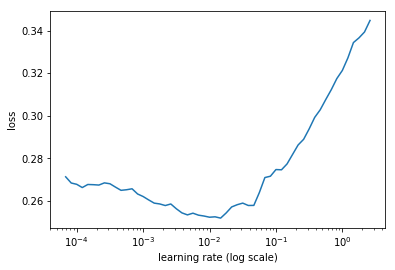

In [106]:
m.sched.plot()

In [107]:
lr=10**-3

In [108]:
def accuracy(y_pred, targ):
    return np.count_nonzero(torch.round(y_pred) == targ) / len(y_pred)

In [109]:
m.fit(lr, 2, cycle_len=1, cycle_mult=2, metrics=[accuracy])

epoch      trn_loss   val_loss   accuracy                  
    0      0.354195   0.263505   0.51461   
    1      0.227437   0.192309   0.700392                  
    2      0.154657   0.178648   0.72874                   


[array([0.17865]), 0.7287396423898822]